### ML FINAL

Sirisha Ginnu

model - ResNet50 , sequential - custom output layer 

traning startegy - torch cuda amp gradscaler and autotcast, CosineAnnealingLR

added warmup scheduler

Added Loss function CrossEntropyLoss
                
num_epochs = 12

Validation Accuracy: 86.23%

Using device: cuda
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Number of classes: 11


/tmp/ipykernel_11320/4269923119.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_11320/4269923119.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/14, Train Loss: 2.4247, Val Loss: 2.4220
Epoch 2/14, Train Loss: 1.3425, Val Loss: 0.9606
Epoch 3/14, Train Loss: 1.1404, Val Loss: 1.0263
Epoch 4/14, Train Loss: 1.1354, Val Loss: 1.0008
Epoch 5/14, Train Loss: 1.1328, Val Loss: 1.1101
Epoch 6/14, Train Loss: 1.1650, Val Loss: 1.0840


/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 7/14, Train Loss: 1.1048, Val Loss: 0.9914
Epoch 8/14, Train Loss: 1.0468, Val Loss: 1.0373
Epoch 9/14, Train Loss: 1.0355, Val Loss: 1.0022
Epoch 10/14, Train Loss: 0.9954, Val Loss: 0.9532
Epoch 11/14, Train Loss: 0.9495, Val Loss: 0.9939
Epoch 12/14, Train Loss: 0.9011, Val Loss: 0.8718
Epoch 13/14, Train Loss: 0.8454, Val Loss: 0.8443
Epoch 14/14, Train Loss: 0.8251, Val Loss: 0.8201


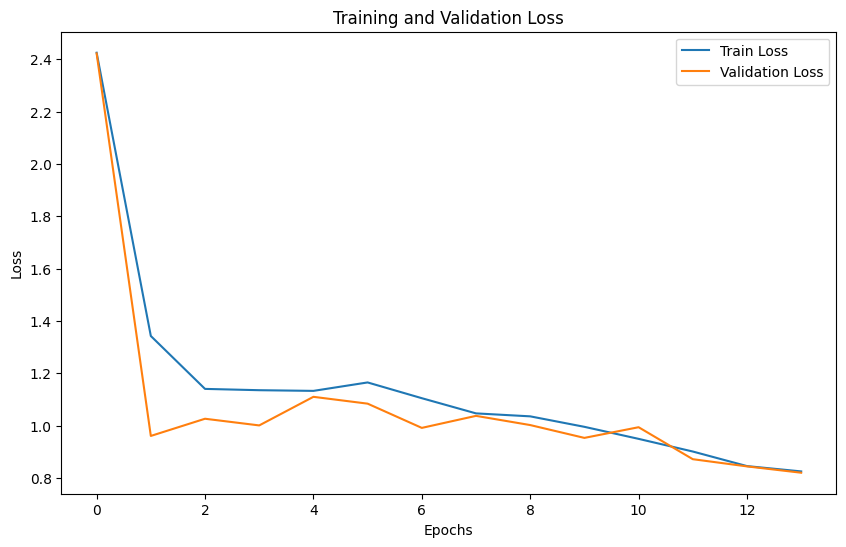

Validation Accuracy: 87.98%


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # Requires warmup_scheduler library
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'  # Replace with your dataset path

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(30, shear=20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print class names
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Model Definition
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)

# Freeze initial layers for fine-tuning
for param in model.layer1.parameters():
    param.requires_grad = False

# Move model to device
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)

# Scheduler: Warmup + Cosine Annealing
base_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1.0, total_epoch=5, after_scheduler=base_scheduler)

# Mixed Precision Training
scaler = GradScaler()

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=14):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed precision training with autocast
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Scheduler step
        scheduler.step()

    return train_loss_history, val_loss_history

# Train the model
num_epochs = 14
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate Model on Validation Set
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")
